Import và cấu hình

In [248]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision import transforms
import seaborn as sns
import random
from collections import Counter

# Cấu hình
dataset_path = r'C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset'  # Thay bằng đường dẫn thật
img_size = (64, 64)
categories = sorted(os.listdir(dataset_path))
print(f"Found {len(categories)} categories: {categories}")


Found 25 categories: ['apple', 'bowtie', 'circle', 'cloud', 'cup', 'diamond', 'fish', 'guitar', 'hat', 'headphones', 'ladder', 'laptop', 'leaf', 'moon', 'pants', 'pencil', 'rectangle', 'soccer_ball', 'sock', 'star', 'sun', 't-shirt', 'triangle', 'watermelon', 'wine glass']


Load và đếm dữ liệu

C:\Users\PC\AppData\Local\Temp\ipykernel_14496\1724384681.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data_count.keys()), y=list(data_count.values()), palette="viridis")


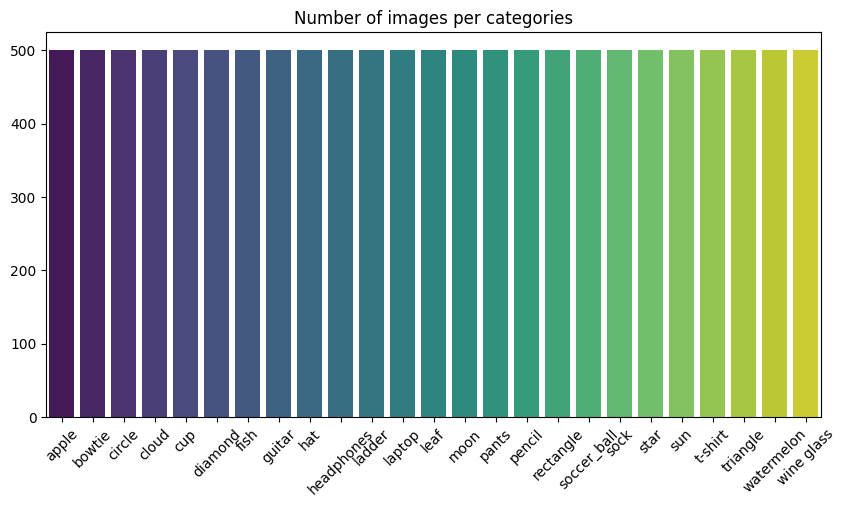

In [249]:
# Đếm số lượng ảnh mỗi lớp
data_count = {}
for c in categories:
    folder = os.path.join(dataset_path, c)
    count = len(os.listdir(folder))
    data_count[c] = count

# Trực quan hóa số lượng ảnh mỗi lớp
plt.figure(figsize=(10,5))
sns.barplot(x=list(data_count.keys()), y=list(data_count.values()), palette="viridis")
plt.title("Number of images per categories")
plt.xticks(rotation=45)
plt.show()

# total_images = sum(data_count.values())
# for c, count in data_count.items():
#     print(f"{c}: {count} ảnh ({count/total_images*100:.2f}%)")


Kiểm tra kích thước và tỉ lệ ảnh

In [240]:
# img_shapes = []
# for c in categories:
#     folder = os.path.join(dataset_path, c)
#     for img_name in os.listdir(folder)[:50]:
#         img = Image.open(os.path.join(folder, img_name)).convert("L")
#         img_shapes.append(img.size)

# sizes = np.array(img_shapes)
# plt.figure(figsize=(6,4))
# plt.scatter(sizes[:,0], sizes[:,1], alpha=0.6)
# plt.title("Kích thước ảnh (width, height)")
# plt.xlabel("Width"); plt.ylabel("Height")
# plt.show()

# unique_sizes = set(img_shapes)
# print(f"Tổng số kích thước khác nhau: {len(unique_sizes)}")


Total number of different sizes: 11
  64x64: 7320 images (58.56%)
  1668x2154: 2306 images (18.45%)
  627x563: 1316 images (10.53%)
  455x227: 877 images (7.02%)
  475x309: 378 images (3.02%)
  408x293: 221 images (1.77%)
  653x563: 55 images (0.44%)
  421x293: 24 images (0.19%)
  980x980: 1 images (0.01%)
  1280x720: 1 images (0.01%)
  423x393: 1 images (0.01%)


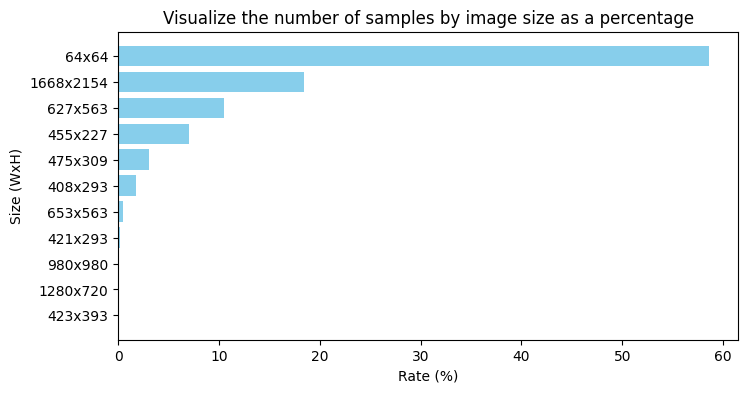

In [251]:

# --- Lấy kích thước ảnh ---
img_shapes = []
for c in categories:
    folder = os.path.join(dataset_path, c)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("L")
            img_shapes.append(img.size)
        except Exception as e:
            print(f"Lỗi khi đọc {img_path}: {e}")

# --- Đếm tần suất mỗi kích thước ---
shape_counts = Counter(img_shapes)
total_images = sum(shape_counts.values())

# Tạo mảng dữ liệu để trực quan
sizes = np.array(list(shape_counts.keys()))
counts = np.array(list(shape_counts.values()))
percents = counts / total_images * 100

# --- In thống kê ---
print(f"Total number of different sizes: {len(shape_counts)}")
for (w, h), cnt in shape_counts.most_common(len(shape_counts)):
    print(f"  {w}x{h}: {cnt} images ({cnt/total_images*100:.2f}%)")

# --- Biểu đồ thanh  ---
top10 = shape_counts.most_common(len(shape_counts))
labels = [f"{w}x{h}" for (w, h), _ in top10]
values = [v for _, v in top10]
percent_values = [v / total_images * 100 for v in values]


plt.figure(figsize=(8,4))
plt.barh(labels, percent_values, color='skyblue')
plt.xlabel("Rate (%)")
plt.ylabel("Size (WxH)")
plt.title("Visualize the number of samples by image size as a percentage")
plt.gca().invert_yaxis()
plt.show()


Chuẩn hóa ảnh về (64,64) & xử lý nét

In [259]:
import os
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import random

# --- Cấu hình ---
dataset_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\dataset"                 # thư mục gốc chứa dataset
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\processed_line_resize_dataset"        # nơi lưu ảnh đã xử lý
img_size = (64, 64)                      # resize về kích thước cố định

# --- Danh sách nhãn ---
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# --- Hàm xử lý ảnh ---
def preprocess_image(img_path):
    img = Image.open(img_path).convert("L")  # chuyển sang grayscale
    img = ImageOps.invert(img)               # đảo ngược màu (nền đen, nét trắng)
    img = img.resize(img_size)               # chuẩn hóa kích thước
    img = ImageEnhance.Contrast(img).enhance(5.0)  # tăng tương phản
    return img

# --- Xử lý toàn bộ dataset ---
for category in categories:
    input_folder = os.path.join(dataset_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"processing category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        output_img_path = os.path.join(output_folder, img_name)

        try:
            img = preprocess_image(img_path)
            img.save(output_img_path)
        except Exception as e:
            print(f"error at image {img_name}: {e}")

print("Complete processing of the entire dataset!")




processing category: apple
processing category: bowtie
processing category: circle
processing category: cloud
processing category: cup
processing category: diamond
processing category: fish
processing category: guitar
processing category: hat
processing category: headphones
processing category: ladder
processing category: laptop
processing category: leaf
processing category: moon
processing category: pants
processing category: pencil
processing category: rectangle
processing category: soccer_ball
processing category: sock
processing category: star
processing category: sun
processing category: t-shirt
processing category: triangle
processing category: watermelon
processing category: wine glass
Complete processing of the entire dataset!


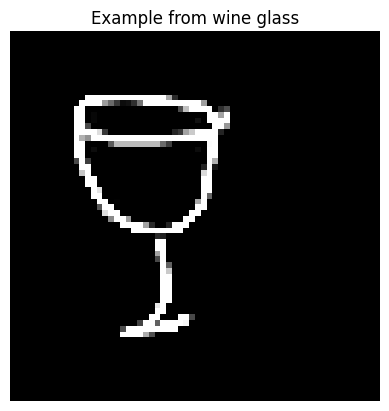

In [260]:
# --- Hiển thị thử một ảnh ngẫu nhiên ---
sample_category = random.choice(categories)
sample_path = os.path.join(output_path, sample_category, random.choice(os.listdir(os.path.join(output_path, sample_category))))
img = Image.open(sample_path)
plt.imshow(img, cmap='gray')
plt.title(f"Example from {sample_category}")
plt.axis('off')
plt.show()

chia tập dữ liệu

In [265]:
# --- Cell: Split Dataset into Train / Test / Eval ---
import os
import random
import shutil

# --- Cấu hình ---
input_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\processed_line_resize_dataset"            # thư mục dữ liệu đầu vào
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset"           # thư mục lưu kết quả
train_ratio = 0.7                          
test_ratio = 0.15                           
eval_ratio = 0.15                           

# --- Kiểm tra tổng tỉ lệ ---
assert abs(train_ratio + test_ratio + eval_ratio - 1.0) < 1e-6, "Tổng tỉ lệ phải = 1.0"

# --- Tạo thư mục đầu ra ---
splits = ["train", "test", "eval"]
for split in splits:
    split_path = os.path.join(output_path, split)
    os.makedirs(split_path, exist_ok=True)

# --- Lấy danh sách categories ---
categories = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

# --- Hàm chia dữ liệu ---
def split_and_copy(category):
    input_folder = os.path.join(input_path, category)
    images = os.listdir(input_folder)
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    test_end = int((train_ratio + test_ratio) * total)

    split_dict = {
        "train": images[:train_end],
        "test": images[train_end:test_end],
        "eval": images[test_end:]
    }

    for split, img_list in split_dict.items():
        split_folder = os.path.join(output_path, split, category)
        os.makedirs(split_folder, exist_ok=True)

        for img_name in img_list:
            src = os.path.join(input_folder, img_name)
            dst = os.path.join(split_folder, img_name)
            shutil.copy(src, dst)

    print(f"Category '{category}' is splitted: "
          f"{train_end} train, {test_end-train_end} test, {total-test_end} eval")

# --- Chia dữ liệu cho toàn bộ categories ---
for category in categories:
    split_and_copy(category)

print("\nDone splitting data into train/test/eval!")


Category 'apple' is splitted: 350 train, 75 test, 75 eval
Category 'bowtie' is splitted: 350 train, 75 test, 75 eval
Category 'circle' is splitted: 350 train, 75 test, 75 eval
Category 'cloud' is splitted: 350 train, 75 test, 75 eval
Category 'cup' is splitted: 350 train, 75 test, 75 eval
Category 'diamond' is splitted: 350 train, 75 test, 75 eval
Category 'fish' is splitted: 350 train, 75 test, 75 eval
Category 'guitar' is splitted: 350 train, 75 test, 75 eval
Category 'hat' is splitted: 350 train, 75 test, 75 eval
Category 'headphones' is splitted: 350 train, 75 test, 75 eval
Category 'ladder' is splitted: 350 train, 75 test, 75 eval
Category 'laptop' is splitted: 350 train, 75 test, 75 eval
Category 'leaf' is splitted: 350 train, 75 test, 75 eval
Category 'moon' is splitted: 350 train, 75 test, 75 eval
Category 'pants' is splitted: 350 train, 75 test, 75 eval
Category 'pencil' is splitted: 350 train, 75 test, 75 eval
Category 'rectangle' is splitted: 350 train, 75 test, 75 eval
Cate

Chuẩn hóa giá trị pixel

In [266]:
# --- Cell: Normalization [0,1] + Visualization + Save ---
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# --- Cấu hình ---
input_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset\train"             # thư mục ảnh đã xử lý (invert, resize, contrast)
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset\normalized_train"           # nơi lưu ảnh đã chuẩn hóa
os.makedirs(output_path, exist_ok=True)

# --- Hàm chuẩn hóa ---
def normalize_image(img_array):
    return img_array.astype("float32") / 255.0

# --- Hàm trực quan ---
def visualize_before_after(img_path):
    img = Image.open(img_path).convert("L")
    img_array = np.array(img)
    norm_img = normalize_image(img_array)

    # Hiển thị ảnh gốc và ảnh chuẩn hóa
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_array, cmap="gray")
    ax[0].set_title("Original iamge (0–255)")
    ax[0].axis("off")

    ax[1].imshow(norm_img, cmap="gray")
    ax[1].set_title("Image after normalization [0,1]")
    ax[1].axis("off")

    plt.show()

    return norm_img

# --- Chuẩn hóa toàn bộ dataset ---
categories = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

for category in categories:
    input_folder = os.path.join(input_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Standardize category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        try:
            img = Image.open(img_path).convert("L")
            norm_img = normalize_image(np.array(img))
            
            # Lưu lại ảnh đã chuẩn hóa (nhân lại 255 để lưu được dạng ảnh)
            Image.fromarray((norm_img * 255).astype(np.uint8)).save(os.path.join(output_folder, img_name))
        except Exception as e:
            print(f"error at image {img_name}: {e}")

print("Complete normalization of the entire dataset!")





Standardize category: apple
Standardize category: bowtie
Standardize category: circle
Standardize category: cloud
Standardize category: cup
Standardize category: diamond
Standardize category: fish
Standardize category: guitar
Standardize category: hat
Standardize category: headphones
Standardize category: ladder
Standardize category: laptop
Standardize category: leaf
Standardize category: moon
Standardize category: pants
Standardize category: pencil
Standardize category: rectangle
Standardize category: soccer_ball
Standardize category: sock
Standardize category: star
Standardize category: sun
Standardize category: t-shirt
Standardize category: triangle
Standardize category: watermelon
Standardize category: wine glass
Complete normalization of the entire dataset!


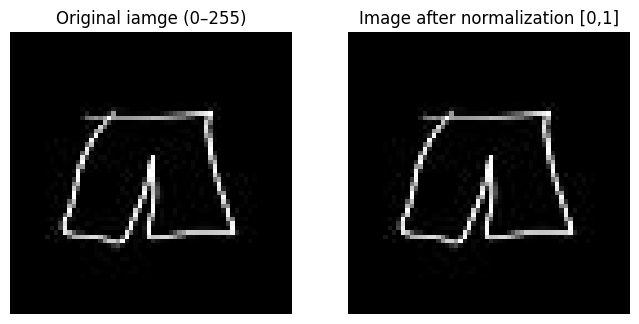

In [267]:
# --- Hiển thị thử một ảnh ngẫu nhiên ---
sample_category = random.choice(categories)
sample_path = os.path.join(input_path, sample_category, random.choice(os.listdir(os.path.join(input_path, sample_category))))
norm_img = visualize_before_after(sample_path)

Tăng cường dữ liệu (Data Augmentation)

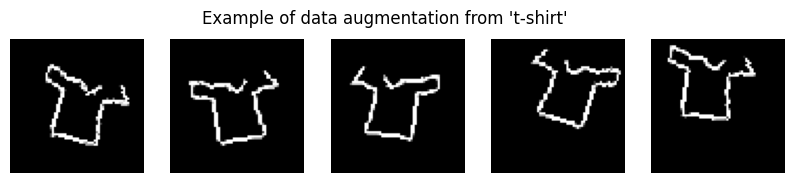

Enhancing data for category: apple
Enhancing data for category: bowtie
Enhancing data for category: circle
Enhancing data for category: cloud
Enhancing data for category: cup
Enhancing data for category: diamond
Enhancing data for category: fish
Enhancing data for category: guitar
Enhancing data for category: hat
Enhancing data for category: headphones
Enhancing data for category: ladder
Enhancing data for category: laptop
Enhancing data for category: leaf
Enhancing data for category: moon
Enhancing data for category: pants
Enhancing data for category: pencil
Enhancing data for category: rectangle
Enhancing data for category: soccer_ball
Enhancing data for category: sock
Enhancing data for category: star
Enhancing data for category: sun
Enhancing data for category: t-shirt
Enhancing data for category: triangle
Enhancing data for category: watermelon
Enhancing data for category: wine glass
Complete data augmentation of the entire dataset!


In [268]:
# --- Cell: Data Augmentation ---
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# --- Cấu hình ---
input_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset\normalized_train"         # thư mục ảnh đã chuẩn hóa [0,1]
output_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset\augmented_train"          # nơi lưu ảnh tăng cường dữ liệu
os.makedirs(output_path, exist_ok=True)

# --- Pipeline transform ---
transform = transforms.Compose([
    transforms.RandomRotation(20),                  # xoay ±20°
    transforms.RandomHorizontalFlip(),              # lật ngang ngẫu nhiên
    transforms.RandomAffine(0, translate=(0.1,0.1)) # tịnh tiến nhẹ
])

# --- Lấy danh sách category ---
categories = [d for d in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, d))]

# --- Chọn ảnh ngẫu nhiên để trực quan ---
sample_category = random.choice(categories)
sample_folder = os.path.join(input_path, sample_category)
sample_img_path = os.path.join(sample_folder, random.choice(os.listdir(sample_folder)))

img = np.array(Image.open(sample_img_path).convert("L"))

# --- Trực quan hoá 5 ảnh tăng cường từ cùng 1 ảnh ---
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    aug_img = transform(Image.fromarray(img))
    axes[i].imshow(aug_img, cmap="gray")
    axes[i].axis("off")
plt.suptitle(f"Example of data augmentation from '{sample_category}'")
plt.show()

# --- Áp dụng augment cho toàn bộ dataset ---
for category in categories:
    input_folder = os.path.join(input_path, category)
    output_folder = os.path.join(output_path, category)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Enhancing data for category: {category}")
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        try:
            img = Image.open(img_path).convert("L")

            # Sinh ra 3 ảnh tăng cường (bạn có thể đổi số lượng)
            for i in range(3):
                aug_img = transform(img)
                aug_img.save(os.path.join(output_folder, f"aug_{i}_{img_name}"))

        except Exception as e:
            print(f"error at image {img_name}: {e}")

print("Complete data augmentation of the entire dataset!")


trực quan hóa

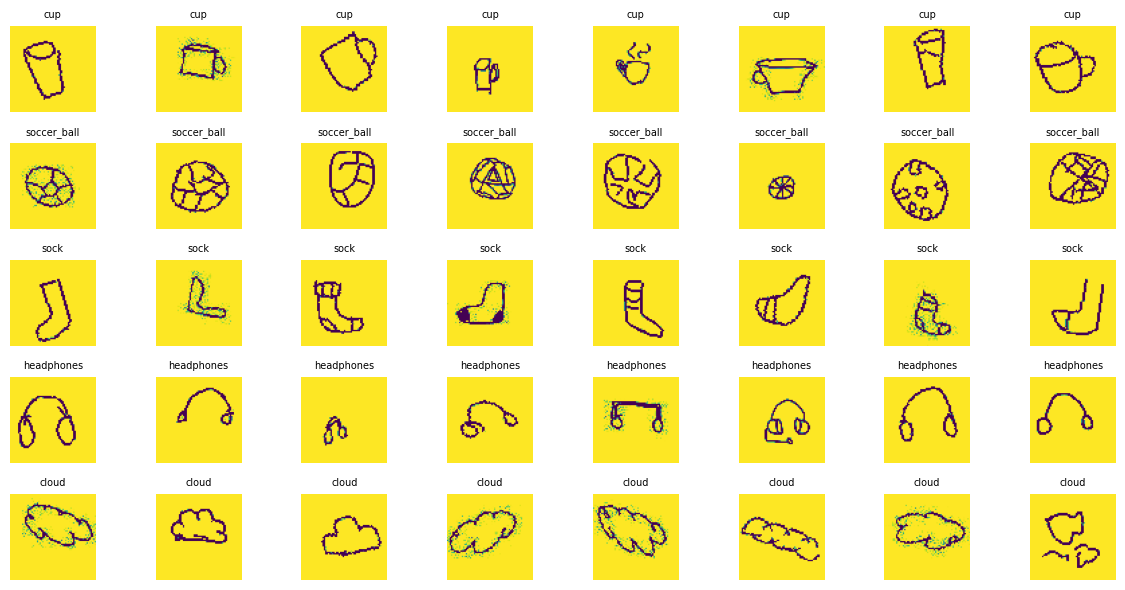

In [269]:
def show_grid(dataset_path, n=40):
    all_imgs = []
    all_labels = []
    for c in random.sample(categories, 5):
        folder = os.path.join(dataset_path, c)
        imgs = random.sample(os.listdir(folder), n // 5)
        for im in imgs:
            path = os.path.join(folder, im)
            all_imgs.append(preprocess_image(path))
            all_labels.append(c)
    fig, axes = plt.subplots(5, n//5, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(all_imgs[i], cmap='viridis')
        ax.set_title(all_labels[i], fontsize=7)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

dataset_path = r"C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\training_dataset\augmented_train"
show_grid(dataset_path)

In [ ]:
# def show_class_mean(dataset_path, categories, img_size):
#     fig, axes = plt.subplots(2, 5, figsize=(10,5))
#     for i, c in enumerate(random.sample(categories, 10)):
#         folder = os.path.join(dataset_path, c)
#         imgs = [preprocess_image(os.path.join(folder, img)) for img in random.sample(os.listdir(folder), 50)]
#         mean_img = np.mean(imgs, axis=0)
#         ax = axes[i//5, i%5]
#         ax.imshow(mean_img, cmap='viridis')
#         ax.set_title(c)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# dataset_path = r'C:\Users\PC\OneDrive\Desktop\DPL302m\QuickDraw\augmented_dataset'
# show_class_mean(dataset_path, categories, img_size)
